In [25]:
import pandas as pd
# Load Data
url = 'https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/dataset/mulestudio.csv'
raw_data = pd.read_csv(url)
raw_data.columns
raw_data.head(6)

,issuekey,title,description,storypoint
0,STUDIO-95,Support for request/reply,request/reply http://www.mulesoft.org/documen...,13
1,STUDIO-280,Cannot import a Studio project from Git withou...,Steps to reproduce: 1. Create a simple Mule...,3
2,STUDIO-382,Changes to Java code do not get hot deployed,Java source changes don't get picked up right ...,5
3,STUDIO-459,Unable to add a response when creating a secon...,Unable to add a response when creating a secon...,8
4,STUDIO-618,Namespaces in the XML view are not being remo...,When you add an element and then you remove it...,8
5,STUDIO-781,Would save time to be given the option to crea...,Add a button in the ClassFieldEditor to create...,5


In [2]:
# Check for missing values
raw_data.isnull().sum()


issuekey       0
title          0
description    0
storypoint     0
dtype: int64

In [3]:

# Examine storypoints summary statistics
raw_data.storypoint.describe()

count    732.000000
mean       6.396175
std        5.385687
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       34.000000
Name: storypoint, dtype: float64

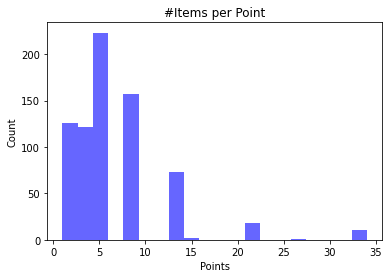

In [4]:
# Visualize number of storypoints distribution
import matplotlib.pyplot as plt
plt.hist(raw_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()


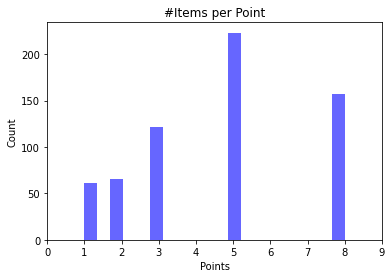

In [5]:
# Zoom in on most common data representing 75% of the dataset
import numpy as np
frequent_data = raw_data.query('storypoint <= 8')
plt.hist(frequent_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.xticks(np.arange(0, 10, 1)) 
plt.show()

In [6]:
# Examine distribution in detail
raw_data.groupby('storypoint').size()

storypoint
1      61
2      65
3     121
5     223
8     157
13     73
15      2
21     18
26      1
34     11
dtype: int64

In [7]:
average_storypoints = raw_data['storypoint'].mean()
average_storypoints

6.396174863387978

In [26]:
#Categories: small = 1 - 3, medium = 4 - 8, large = 9 - max

raw_data.loc[raw_data.storypoint <= 2, 'storypoint'] = 0 #small
raw_data.loc[(raw_data.storypoint > 2) & (raw_data.storypoint <= 8), 'storypoint'] = 1 #medium
raw_data.loc[(raw_data.storypoint > 8) & (raw_data.storypoint <= 15), 'storypoint'] = 2 #large
raw_data.loc[raw_data.storypoint > 15, 'storypoint'] = 3 #very large
raw_data.groupby('storypoint').size()



storypoint
0    126
1    501
2     75
3     30
dtype: int64

This shows that 5 the most common number of storypoints assigned to an issue/requirement.

In [27]:
################### Data Preprocessing ###################################

import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('stopwords')

# Tokenize
raw_data['tokens'] = raw_data['description'].apply(lambda x : nltk.word_tokenize(x))

type(raw_data['description'][0])




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


str

In [28]:
# Convert all words to lower case
raw_data['tokens'] = raw_data['tokens'].apply(lambda x : [w.lower() for w in x])

# Remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w.translate(table) for w in x])

# Remove tokens that are not alphabetic
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w for w in x if w.isalpha()])

# Remove stop words
stop_words = stopwords.words('english')
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w for w in x if w not in stop_words])
# Remove project specific stop words
specific_stop_words = ['http', 'mule', 'studio']
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w for w in x if w not in specific_stop_words])
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: nltk.Text(x))

# Lemmatization
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x ])

# Stemming
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [porter.stem(w) for w in x ])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# Vocabulary
vocabulary = set([item for sublist in list(raw_data['tokens']) for item in sublist]) # list of unique words
vocabulary_size = len(vocabulary)
vocabulary_size

2748

In [0]:
# Frequency distribution of words
all_words = [item for sublist in list(raw_data['tokens']) for item in sublist]
len(all_words)
from nltk.probability import FreqDist
fdist = FreqDist(all_words)


In [31]:
list(raw_data['tokens'])[0]

['requestrepli',
 'wwwmulesoftorgdocumentationdisplaycurrentroutingmessageprocessor',
 'routingmessageprocessorsrequestrepli',
 'mockup',
 'corpwikimulesourcecomdisplaywprequestrepli',
 'requestreplymockup']

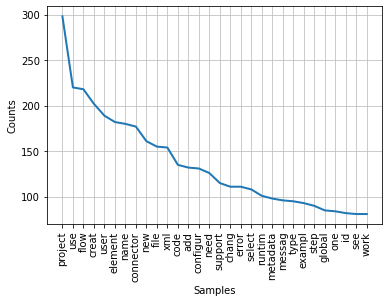

In [32]:
# Frequency Distribution of Words Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [0]:
# Split data into traning and testing
split_ratio = 0.7
total_number_of_datapoints = len(raw_data.index)
train_number_of_datapoints = int(total_number_of_datapoints * split_ratio)

train_set = raw_data.iloc[:train_number_of_datapoints, :]
test_set = raw_data.iloc[train_number_of_datapoints:, :]

In [0]:
tokens = list(train_set['tokens'])
tokens = [str(i) for i in tokens]

Count Vectorization (One-Hot-Encoding)

In [35]:
# Create our vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(list(train_set['description']))

# Build the classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.01)

#  Train the classifier
clf.fit(vectors, train_set['storypoint'].values)

# Get the test vectors
vectors_test = vectorizer.transform(list(test_set['description']))

# Predict and score the vectors
from sklearn import metrics
pred = clf.predict(vectors_test)
acc_score = metrics.accuracy_score( test_set['storypoint'].values, pred)
f1_score = metrics.f1_score( test_set['storypoint'].values, pred, average='macro')

print('Total accuracy classification score: {}'.format(acc_score))
print('Total F1 classification score: {}'.format(f1_score))


Total accuracy classification score: 0.5818181818181818
Total F1 classification score: 0.28412883234770264


Word2Vec

In [0]:
import gensim
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary = True) 



In [19]:
# Check dimension of word vectors
model.vector_size



300

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


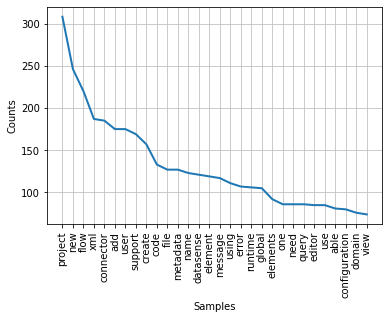

In [44]:
import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('stopwords')

issue_titles = raw_data['title']
issue_descriptions = raw_data['description']

# cocat title and description
titles_and_descriptions = raw_data['title'] + raw_data['description']

# Create a list of strings, one for each title
#titles_list = [title for title in issue_titles]
#descriptions_list = [description for description in issue_descriptions]
titles_and_descriptions_list = [title for title in titles_and_descriptions]

# Collapse the list of strings into a single long string for processing
#big_title_string = ' '.join(titles_list)
big_title_string = ' '.join(titles_and_descriptions_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [w for w in words if w not in stop_words]

# Remove project specific stop words
specific_stop_words = ['http', 'mule', 'studio']
words = [w for w in words if w not in specific_stop_words]


# Frequency distribution of words
from nltk.probability import FreqDist
fdist = FreqDist(words)
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()



In [45]:
big_title_string

'Support for request/replyrequest/reply  http://www.mulesoft.org/documentation/display/current/Routing+Message+Processors#RoutingMessageProcessors-RequestReply  Mockups here: http://corp.wiki.mulesource.com/display/WP/Request-Reply#Request-Reply-Mockups  Cannot import a Studio project from Git without errorsSteps to reproduce:    1. Create a simple Mule Studio project (for instance: the Echo example)  2. Push it into GitHub, pull/clone the repository into your local instance  3. Open up a brand new workspace  4. Goto Import/Git/Projects from Git  5. Select the local copy of your GitHub repository  6. Select import existing projects  7. Select the project created above  8. The import fails due to missing directories (see screenshot)    Note that if I do Import --> Mule project it works but then it doesn\'t recognise that it is a project managed by git so I cannot commit changes.    This is blocking me for the work I am doing with examples.    Edit: workaround: perform a Clean operation 

In [46]:

# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

# Averaging Word Embeddings
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

# Preprocess the corpus
def preprocessing(data_list):
  corpus = [preprocess(title) for title in data_list]

  # Remove docs that don't include any words in W2V's vocab
  corpus, data_list = filter_docs(corpus, data_list, lambda doc: has_vector_representation(model, doc))

  # Filter out any empty docs
  corpus, data_list = filter_docs(corpus, data_list, lambda doc: (len(doc) != 0))

  y = []
  x = []
  for doc in corpus: # append the vector for each document
      #print(corpus.index(doc))
      x.append(document_vector(model, doc))
      y.append(raw_data['storypoint'][corpus.index(doc)])
      
  X = np.array(x) # list to array
  y = np.array(y)
  return X, y

# Descriptions
X = preprocessing(descriptions_list)[0]
y = preprocessing(descriptions_list)[1]

# 80% of data goes to training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)



2 docs removed
0 docs removed
2 docs removed
0 docs removed


In [47]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Accuracy
y_pred_rounded = [round(prediction,0) for prediction in y_pred ]
y_pred_rounded = [int(prediction) for prediction in y_pred_rounded]

from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred_rounded)
print('Total accuracy classification score: {}'.format(acc_score))

[15:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total accuracy classification score: 0.7123287671232876


In [48]:
# Build the classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.3424657534246575


In [52]:
# Build the classifier
from sklearn import tree
clf = tree.DecisionTreeClassifier()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.5068493150684932


In [58]:
# Build the classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.7328767123287672


In [59]:
# Build the classifier
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.6164383561643836


In [53]:
# Build the classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.726027397260274


In [54]:
# Build the classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.5342465753424658


In [55]:
# Build the classifier
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.6164383561643836


In [56]:
# Build the classifier
from sklearn.svm import SVC
clf = SVC()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.726027397260274


In [60]:
# Build the classifier
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.6506849315068494


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [61]:
# Build the classifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.7123287671232876


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [62]:
# Build the classifier
from sklearn.gaussian_process import GaussianProcessClassifier
clf = GaussianProcessClassifier()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.726027397260274
